In [67]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import APSIMGraphHelpers as AGH
import GraphHelpers as GH
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.dates as mdates
import MathsUtilities as MUte
import shlex # package to construct the git command to subprocess format
import subprocess 
import sqlite3
import scipy.optimize 
from skopt import gp_minimize
from skopt.callbacks import CheckpointSaver
from skopt import load
from skopt.plots import plot_convergence
import matplotlib.gridspec as gridspec
import xmltodict, json

import winsound
frequency = 2500  # Set Frequency To 2500 Hertz
duration = 1000  # Set Duration To 1000 ms == 1 second
%matplotlib inline

In [68]:
def runDevModelItter(paramValues):
    retVal =runModelItter(paramNames,paramValues,SimulationNames,fittingVars,TreeFilePath)
    return retVal

In [69]:
paramNames = ["SurfaceKL",
        "KLReductionFactor",
        "KLReductionDepth",
        "gsmax",
        "r50"]

In [70]:
bounds = [(0.05,0.3),
          (0.002,0.007),
          (230,270),
          (0.001,0.015),
          (100,200)]

In [71]:
Peach = CheckPoint = load("Peach FitsCheckpoint.pkl")

In [72]:
KiwiFruit = CheckPoint = load("KiwiFruit FitsCheckpoint.pkl")

In [73]:
Apple = CheckPoint = load("Apple FitsCheckpoint.pkl")

In [74]:
Grape = CheckPoint = load("Grape FitsCheckpoint.pkl")

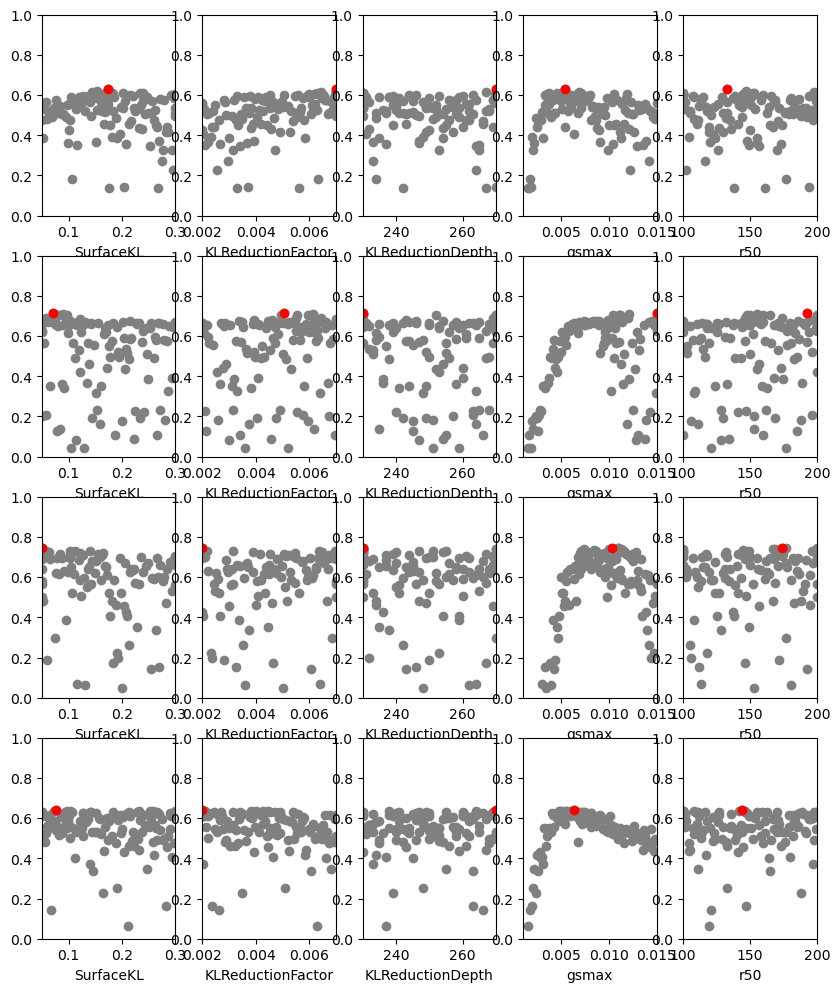

In [75]:
Graph = plt.figure(figsize=(10,12))
panpos=1;
for c in [Peach,KiwiFruit,Apple,Grape]:
    for v in [0,1,2,3,4]:
        ax = Graph.add_subplot(4,5,panpos)
        pos=0
        for f in c.func_vals:
            if (-f > -c.fun * 0.01):
                plt.plot(c.x_iters[pos][v],-f,'o',color='grey')
            pos+=1
        plt.plot(c.x[v],-c.fun,'o',color='red')
        plt.xlabel(paramNames[v])
        plt.xlim(bounds[v][0],bounds[v][1])
        plt.ylim(0,1)
        panpos+=1

In [76]:
Peach.x

[0.1733350981384637, 0.007, 270, 0.005413917409321243, 133]

In [77]:
KiwiFruit.x

[0.07155379764625633, 0.0050652663137057095, 230, 0.015, 193]

In [78]:
Apple.x

[0.05, 0.002, 230, 0.010310147285269342, 174]

In [79]:
Grape.x

[0.07626556712935195, 0.002, 270, 0.0063725944218326076, 144]

In [80]:
AppleDB = pd.DataFrame(columns=paramNames,data=Apple.x_iters)
AppleDB.loc[:,'nse'] = -Apple.func_vals
GrapeDB = pd.DataFrame(columns=paramNames,data=Grape.x_iters)
GrapeDB.loc[:,'nse'] = -Grape.func_vals
PeachDB = pd.DataFrame(columns=paramNames,data=Peach.x_iters)
PeachDB.loc[:,'nse'] = -Peach.func_vals
KiwiFruitDB = pd.DataFrame(columns=paramNames,data=KiwiFruit.x_iters)
KiwiFruitDB.loc[:,'nse'] = -KiwiFruit.func_vals

In [81]:
Crops = ['Apple','Grape','KiwiFruit','Peach']

In [82]:
AllData = pd.concat([AppleDB,GrapeDB,KiwiFruitDB,PeachDB],axis=0,keys=Crops)

In [83]:
for c in Crops:
    AllData.loc[c,'relFit'] =  [AllData.loc[(c,x),'nse']/AllData.loc[c,'nse'].max() for x in AllData.loc[c,'nse'].index]

In [84]:
AllData.sort_index(inplace=True)

In [85]:
BestFits = AllData.loc[AllData.loc[:,'relFit']>0.9,:]

In [86]:
bounds = [(0.05,0.3),
          (0.002,0.007),
          (230,270),
          (0.001,0.015),
          (100,200)]

In [87]:
filt = (BestFits.gsmax>.005)&\
       (BestFits.gsmax<.01)&\
       (BestFits.KLReductionFactor<.004)&\
       (BestFits.KLReductionFactor>.0021)&\
       (BestFits.SurfaceKL < 0.12)&\
       (BestFits.SurfaceKL > 0.10)
       
ChosenValues = BestFits.loc[filt,:].index
BestFits.loc[filt,:]

,,SurfaceKL,KLReductionFactor,KLReductionDepth,gsmax,r50,nse,relFit
Apple,55,0.118814,0.002904,237,0.008939,192,0.687349,0.924113
Grape,26,0.106155,0.003401,247,0.006543,155,0.632729,0.990425
KiwiFruit,8,0.115653,0.003045,260,0.007302,191,0.655233,0.917134
Peach,54,0.118913,0.003583,238,0.005472,129,0.590270,0.937915


In [88]:
ChosenValues

MultiIndex([(    'Apple', 55),
            (    'Grape', 26),
            ('KiwiFruit',  8),
            (    'Peach', 54)],
           )

In [89]:
CropNames=['Apple','Grape','KiwiFruit','Peach']

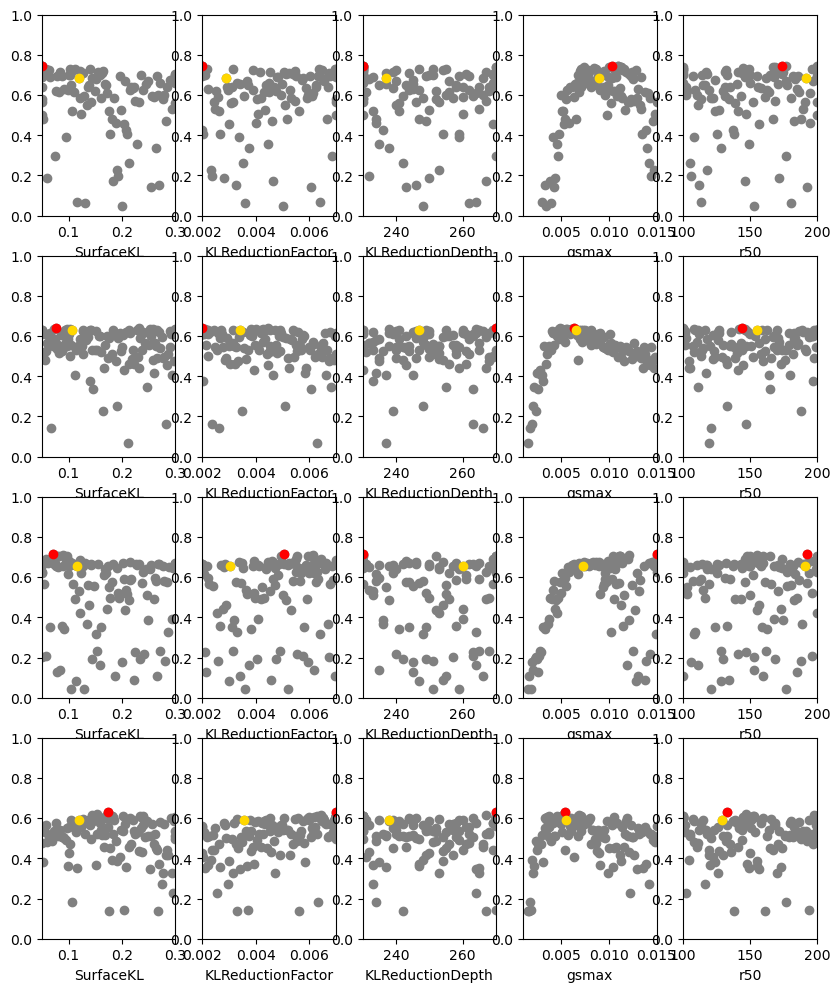

In [90]:
Graph = plt.figure(figsize=(10,12))
panpos=1;
cpos = 0;
for c in [Apple,Grape,KiwiFruit,Peach]:
    for v in [0,1,2,3,4]:
        ax = Graph.add_subplot(4,5,panpos)
        pos=0
        for f in c.func_vals:
            if (-f > -c.fun * 0.01):
                plt.plot(c.x_iters[pos][v],-f,'o',color='grey')
            pos+=1
        plt.plot(c.x[v],-c.fun,'o',color='red')
        plt.plot(BestFits.loc[ChosenValues[cpos],paramNames[v]],BestFits.loc[ChosenValues[cpos],'nse'],'o',color='gold')
        plt.xlabel(paramNames[v])
        plt.xlim(bounds[v][0],bounds[v][1])
        plt.ylim(0,1)
        panpos+=1
    cpos +=1